In [ ]:
# ── Google Colab Setup ────────────────────────────────────────────────────────
# This cell is a no-op when running locally.
import sys, os

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from pathlib import Path
    import subprocess

    repo_dir = Path('/content/cryptoTrading2')

    # 1. Clone repo (skipped if already present)
    if not repo_dir.exists():
        subprocess.run(
            ['git', 'clone', 'https://github.com/kingsuching/cryptoTrading2.git', str(repo_dir)],
            check=True,
        )

    # 2. Set working directory and Python path
    os.chdir(str(repo_dir))
    if str(repo_dir) not in sys.path:
        sys.path.insert(0, str(repo_dir))

    # 3. Install dependencies
    subprocess.run(
        [sys.executable, '-m', 'pip', 'install', '-q',
         'pandas', 'numpy', 'scikit-learn', 'statsmodels', 'prophet',
         'torch', 'matplotlib', 'tqdm', 'transformers',
         'beautifulsoup4', 'requests', 'serpapi'],
        check=True,
    )

    # 4. Write API keys from Colab Secrets (add CMC_KEY & SERPAPI_KEY in the key icon sidebar)
    try:
        from google.colab import userdata
        cmc     = userdata.get('CMC_KEY')     or ''
        serpapi = userdata.get('SERPAPI_KEY') or ''
    except Exception:
        cmc, serpapi = '', ''
    with open('files/API_KEYS.py', 'w') as _f:
        _f.write(f'CMC_KEY = "{cmc}"\nSERPAPI_KEY = "{serpapi}"\n')
    if not cmc or not serpapi:
        print("NOTE: API keys not set — add CMC_KEY & SERPAPI_KEY in Colab Secrets if data fetching is needed.")

    print(f"Colab setup complete. CWD: {os.getcwd()}")

In [ ]:
import os, sys
from pathlib import Path

_root = next((p for p in [Path(os.getcwd()), *Path(os.getcwd()).parents]
              if p.name == 'cryptoTrading2'), None)
if _root:
    os.chdir(str(_root))
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

from files.functions import (
    base_dir,
    fullDataPath,
    dataSetup,
    trainingCols,
    normalize_data,
    create_sequences,
    _get_device,
    _lstm_param_grid,
    _torch_train,
    _seq_future_forecast_torch,
    _standardized_rmse,
    _save_model_artifact,
    _save_metrics,
)
from files.CONSTANTS import *
from implementations.lstm_model import LSTMModel

# LSTM Training

Multi-layer Long Short-Term Memory (LSTM) model using PyTorch for sequential crypto price forecasting.
This notebook normalizes the full multivariate feature set, creates sliding-window sequences,
performs hyperparameter tuning (hidden size, layers, dropout, sequence length, scaler method)
with early stopping, and produces both validation and future price predictions.

Dataset shape: (730, 25)
Features (23): ['open', 'high', 'low', 'volume', 'value', 'SMA_7', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'EMA_20', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_STD', 'Volume_MA_7', 'OBV', 'avg_sentiment']
Date range: 2024-02-24 00:00:00 → 2026-02-22 00:00:00

data_full shape: (730, 24)  (features + target)


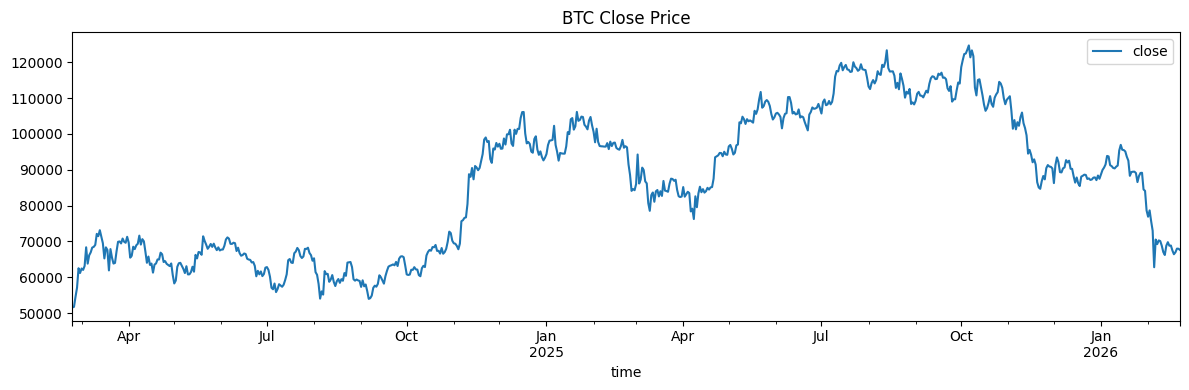


Using device: mps


In [4]:
# ── Step 1: Load and Prepare Data ────────────────────────────────────────────
raw_path = fullDataPath(COIN)
data = pd.read_csv(raw_path)
daily_data = dataSetup(data, trainingColPath=TRAINING_COLUMNS, response=RESPONSE_VARIABLE, number=LIMIT)
cols = trainingCols(TRAINING_COLUMNS)
data_full = daily_data[cols + [RESPONSE_VARIABLE]].copy()
print(f"Dataset shape: {daily_data.shape}")
print(f"Features ({len(cols)}): {cols}")
print(f"Date range: {daily_data.index[0]} → {daily_data.index[-1]}")
print(f"\ndata_full shape: {data_full.shape}  (features + target)")

daily_data[[RESPONSE_VARIABLE]].plot(title=f"{COIN} Close Price", figsize=(12, 4))
plt.tight_layout()
plt.show()

device = _get_device()
print(f"\nUsing device: {device}")

In [5]:
# ── Step 3: Define Hyperparameter Grid ───────────────────────────────────────
param_grid = _lstm_param_grid()
scaler_methods = ['minmax', 'standard']

print(f"LSTM param grid size: {len(param_grid)} configs")
print(f"Scaler methods: {scaler_methods}")
print(f"Total combinations: {len(param_grid) * len(scaler_methods)}")
print("\nSample configs:")
for cfg in param_grid[:3]:
    print(" ", cfg)

LSTM param grid size: 16 configs
Scaler methods: ['minmax', 'standard']
Total combinations: 32

Sample configs:
  {'dropout': 0.1, 'hidden_size': 32, 'num_layers': 1, 'seq_len': 14}
  {'dropout': 0.1, 'hidden_size': 32, 'num_layers': 1, 'seq_len': 30}
  {'dropout': 0.1, 'hidden_size': 32, 'num_layers': 2, 'seq_len': 14}


In [6]:
# ── Step 4: Tune Hyperparameters ─────────────────────────────────────────────
# Tune over scaler methods, sequence lengths, and LSTM architecture hyperparameters
best_score = np.inf
best_combo = None
tuning_results = []

for sm in scaler_methods:
    scaled_data, feat_sc, tgt_sc = normalize_data(data_full, method=sm, target_col=RESPONSE_VARIABLE)
    for params in param_grid:
        seq_len = params['seq_len']
        X_seq, y_seq = create_sequences(scaled_data, sequence_length=seq_len, prediction_horizon=1)
        if len(X_seq) < 10:
            continue
        n_train = max(1, int(len(X_seq) * TRAIN_PCT))
        X_tr = torch.tensor(X_seq[:n_train], dtype=torch.float32)
        y_tr = torch.tensor(y_seq[:n_train].flatten(), dtype=torch.float32)
        X_va = torch.tensor(X_seq[n_train:], dtype=torch.float32)
        y_va = torch.tensor(y_seq[n_train:].flatten(), dtype=torch.float32)
        if len(X_va) == 0:
            continue
        hp = {k: v for k, v in params.items() if k != 'seq_len'}
        m = LSTMModel(input_size=X_tr.shape[2], **hp)
        m, val_loss = _torch_train(m, X_tr, y_tr, X_va, y_va,
                                   lr=1e-3, epochs=30, batch_size=32,
                                   patience=5, device=device)
        rec = {**params, 'scaler': sm, 'val_loss': val_loss}
        tuning_results.append(rec)
        if val_loss < best_score:
            best_score = val_loss
            best_combo = rec.copy()
        print(f"  scaler={sm} seq={seq_len} hidden={params['hidden_size']} "
              f"layers={params['num_layers']} dropout={params['dropout']}  "
              f"val_loss={val_loss:.6f}")

if best_combo is None:
    best_combo = {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.1,
                  'seq_len': 30, 'scaler': 'minmax', 'val_loss': np.nan}

print(f"\nBest combo: {best_combo}")

tuning_df = pd.DataFrame(tuning_results).sort_values('val_loss').reset_index(drop=True)
print("\nTop-5 tuning results:")
print(tuning_df.head(5).to_string(index=False))

  scaler=minmax seq=14 hidden=32 layers=1 dropout=0.1  val_loss=0.000805
  scaler=minmax seq=30 hidden=32 layers=1 dropout=0.1  val_loss=0.000921
  scaler=minmax seq=14 hidden=32 layers=2 dropout=0.1  val_loss=0.186682
  scaler=minmax seq=30 hidden=32 layers=2 dropout=0.1  val_loss=0.233910
  scaler=minmax seq=14 hidden=64 layers=1 dropout=0.1  val_loss=0.001130
  scaler=minmax seq=30 hidden=64 layers=1 dropout=0.1  val_loss=0.001226
  scaler=minmax seq=14 hidden=64 layers=2 dropout=0.1  val_loss=0.284285
  scaler=minmax seq=30 hidden=64 layers=2 dropout=0.1  val_loss=0.182631
  scaler=minmax seq=14 hidden=32 layers=1 dropout=0.2  val_loss=0.003365
  scaler=minmax seq=30 hidden=32 layers=1 dropout=0.2  val_loss=0.001409
  scaler=minmax seq=14 hidden=32 layers=2 dropout=0.2  val_loss=0.108641
  scaler=minmax seq=30 hidden=32 layers=2 dropout=0.2  val_loss=0.090736
  scaler=minmax seq=14 hidden=64 layers=1 dropout=0.2  val_loss=0.001460
  scaler=minmax seq=30 hidden=64 layers=1 dropout=0

In [7]:
# ── Step 5: Train Best Model ──────────────────────────────────────────────────
best_sm = best_combo['scaler']
SEQ_LEN = best_combo['seq_len']
best_hp = {k: v for k, v in best_combo.items()
           if k not in ('seq_len', 'scaler', 'val_loss')}

# Normalize with best scaler on full data
scaled_data, feat_sc, tgt_sc = normalize_data(data_full, method=best_sm, target_col=RESPONSE_VARIABLE)

# ── Step 2 (Train/Val Split) embedded here for final training ─────────────────
X_seq, y_seq = create_sequences(scaled_data, sequence_length=SEQ_LEN, prediction_horizon=1)
n_train = max(1, int(len(X_seq) * TRAIN_PCT))
X_tr = torch.tensor(X_seq[:n_train], dtype=torch.float32)
y_tr = torch.tensor(y_seq[:n_train].flatten(), dtype=torch.float32)
X_va = torch.tensor(X_seq[n_train:], dtype=torch.float32)
y_va_np = y_seq[n_train:].flatten()
y_va_t = torch.tensor(y_va_np, dtype=torch.float32)

print(f"Sequence length: {SEQ_LEN}")
print(f"Train sequences: {len(X_tr)}  |  Val sequences: {len(X_va)}")
print(f"Input size (num features): {X_tr.shape[2]}")
print(f"Scaler: {best_sm}")
print(f"LSTM hyperparams: {best_hp}")

best_model = LSTMModel(input_size=X_tr.shape[2], **best_hp)
best_model, final_val_loss = _torch_train(
    best_model, X_tr, y_tr, X_va, y_va_t,
    lr=1e-3, epochs=50, batch_size=32, patience=10, device=device
)
best_model.eval()
print(f"\nFinal val loss: {final_val_loss:.6f}")

Sequence length: 14
Train sequences: 572  |  Val sequences: 144
Input size (num features): 24
Scaler: minmax
LSTM hyperparams: {'dropout': 0.1, 'hidden_size': 32, 'num_layers': 1}

Final val loss: 0.000744


In [8]:
# ── Step 6: Save Model to models/{COIN}/ ─────────────────────────────────────
_models_dir = os.path.join(base_dir(), 'models', COIN)
os.makedirs(_models_dir, exist_ok=True)
model_pt_path = os.path.join(_models_dir, f'{COIN}_lstm_model.pt')
torch.save(best_model.state_dict(), model_pt_path)
print(f"Model state dict saved to: {model_pt_path}")

meta_path = _save_model_artifact(
    {'feat_scaler': feat_sc, 'tgt_scaler': tgt_sc, 'params': best_combo,
     'seq_len': SEQ_LEN, 'scaler_method': best_sm},
    COIN,
    f'{COIN}_lstm_meta.pkl'
)
print(f"Meta artifact saved to: {meta_path}")

Model state dict saved to: /Users/sucheen/Documents/cryptoTrading2/models/BTC/BTC_lstm_model.pt
Meta artifact saved to: /Users/sucheen/Documents/cryptoTrading2/models/BTC/BTC_lstm_meta.pkl


Validation RMSE:            1,994.84
Standardized RMSE (÷ std):  0.1386


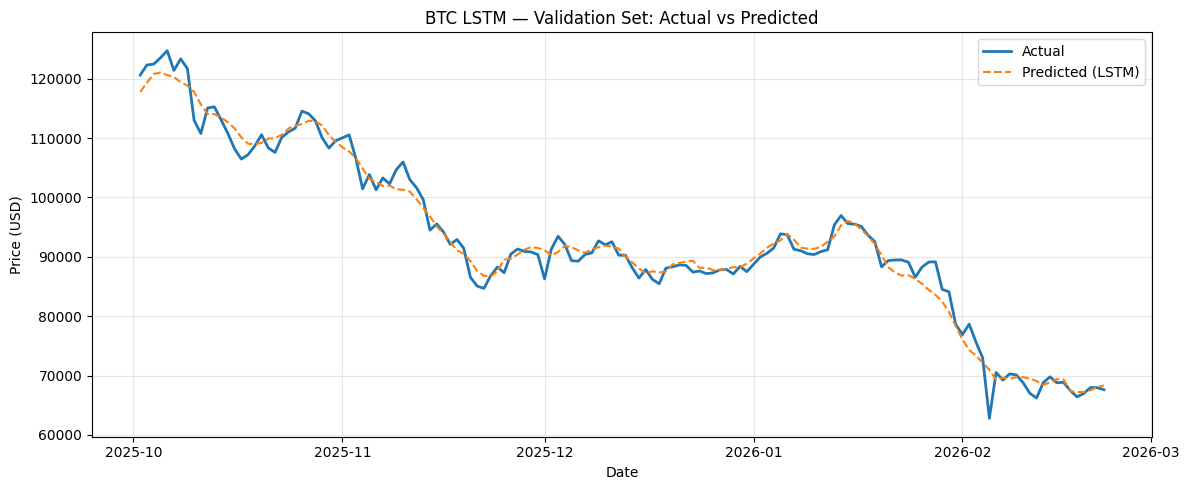

In [9]:
# ── Step 7: Predict on Validation Set ────────────────────────────────────────
best_model.eval()
with torch.no_grad():
    val_preds_scaled = best_model(X_va).squeeze(-1).numpy()

# Inverse-transform predictions and ground truth back to price scale
val_preds = tgt_sc.inverse_transform(val_preds_scaled.reshape(-1, 1)).flatten()
val_true = tgt_sc.inverse_transform(y_va_np.reshape(-1, 1)).flatten()

# Align index with daily_data
val_idx = daily_data.index[n_train + SEQ_LEN: n_train + SEQ_LEN + len(val_preds)]
val_df = pd.DataFrame({'predicted_price': val_preds}, index=val_idx[:len(val_preds)])

# Compute RMSE
rmse = float(np.sqrt(np.mean((val_true - val_preds) ** 2)))
std_rmse = rmse / float(np.std(val_true)) if float(np.std(val_true)) > 0 else rmse
print(f"Validation RMSE:            {rmse:,.2f}")
print(f"Standardized RMSE (÷ std):  {std_rmse:.4f}")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(val_idx[:len(val_true)], val_true, label='Actual', linewidth=2)
ax.plot(val_df.index, val_df['predicted_price'], label='Predicted (LSTM)', linestyle='--')
ax.set_title(f"{COIN} LSTM — Validation Set: Actual vs Predicted")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Future predictions for next 7 days:
            predicted_price
2026-02-23     68484.606288
2026-02-24     68607.114872
2026-02-25     68690.978184
2026-02-26     68747.926930
2026-02-27     68786.456660
2026-02-28     68811.598867
2026-03-01     68828.234624


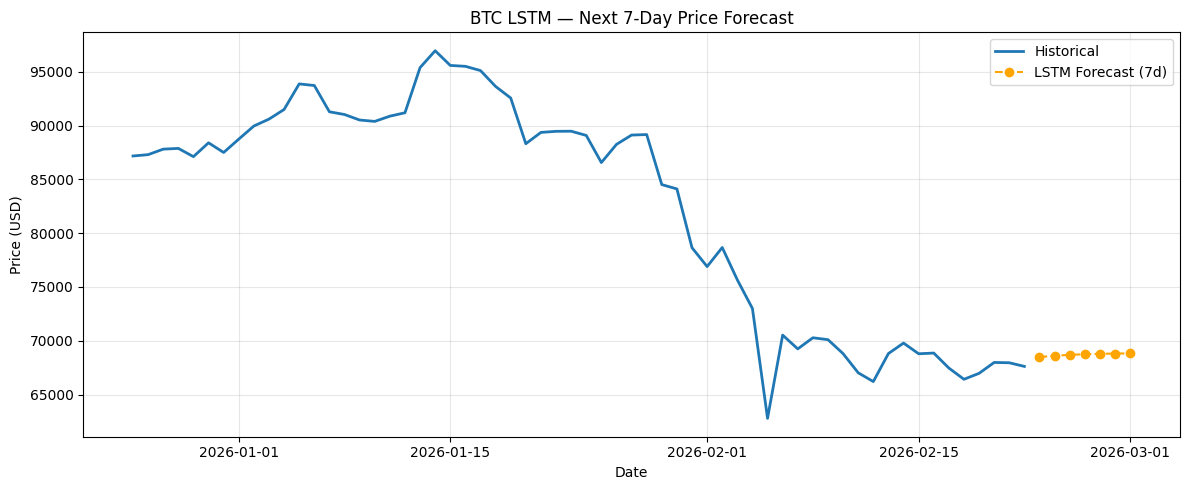

In [10]:
# ── Step 8: Predict Next TEST_DAYS Days ──────────────────────────────────────
future_df = _seq_future_forecast_torch(
    best_model, scaled_data, SEQ_LEN, tgt_sc, daily_data, n=TEST_DAYS
)

print(f"Future predictions for next {TEST_DAYS} days:")
print(future_df.to_string())

# Plot future forecast
fig, ax = plt.subplots(figsize=(12, 5))
hist = daily_data[RESPONSE_VARIABLE].iloc[-60:]
ax.plot(hist.index, hist.values, label='Historical', linewidth=2)
ax.plot(future_df.index, future_df['predicted_price'], marker='o',
        linestyle='--', label=f'LSTM Forecast ({TEST_DAYS}d)', color='orange')
ax.set_title(f"{COIN} LSTM — Next {TEST_DAYS}-Day Price Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ── Step 9: Save Metrics ──────────────────────────────────────────────────────
metrics_path = _save_metrics(std_rmse, COIN, 'lstm')

print(f"Metrics (std RMSE) saved to: {metrics_path}")
print(f"\nStandardized RMSE: {std_rmse:.4f}")
print("Done.")